In [8]:
#  Token-Level Policy Component Extraction with BERT (NER)

# 1. Install required libraries
#!pip install datasets transformers seqeval -q
!pip install --upgrade transformers datasets seqeval -q




In [5]:
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install -U datasets transformers seqeval


Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling torchaudio-2.6

In [2]:
# 2. Import libraries
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, Trainer, TrainingArguments
import numpy as np
from seqeval.metrics import classification_report
from transformers import pipeline
import json


In [13]:
# 3. Upload JSON file
from google.colab import files
uploaded = files.upload()



Saving token_policy_ner_annotated.json to token_policy_ner_annotated (2).json


In [14]:
# 4. Load annotated data
with open("token_policy_ner_annotated.json", "r") as f:
    data = json.load(f)

# 5. Create dataset
raw_dataset = Dataset.from_list(data)



In [15]:
# 6. Define labels
label_list = sorted(set(label for d in data for label in d["labels"]))
label_to_id = {l: i for i, l in enumerate(label_list)}
id_to_label = {i: l for l, i in label_to_id.items()}

# 7. Load tokenizer
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)



In [16]:
# 8. Tokenize and align labels
def tokenize_and_align(example):
    tokenized = tokenizer(example["tokens"], is_split_into_words=True, truncation=True, padding="max_length", max_length=64)
    word_ids = tokenized.word_ids()

    labels = []
    previous_word_idx = None
    for idx in word_ids:
        if idx is None:
            labels.append(-100)
        elif idx != previous_word_idx:
            labels.append(label_to_id[example["labels"][idx]])
        else:
            labels.append(label_to_id[example["labels"][idx]] if example["labels"][idx].startswith("I-") else -100)
        previous_word_idx = idx

    tokenized["labels"] = labels
    return tokenized

# 9. Apply tokenization
encoded_dataset = raw_dataset.map(tokenize_and_align)

# 10. Load model
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), id2label=id_to_label, label2id=label_to_id)



Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [18]:
# 11. Training arguments
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./ner-policy",
    per_device_train_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=10,
)

# 12. Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer)
)

# 13. Train the model
trainer.train()



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-18-62bdaba07034>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,1.799100


TrainOutput(global_step=15, training_loss=1.5584354400634766, metrics={'train_runtime': 103.868, 'train_samples_per_second': 0.481, 'train_steps_per_second': 0.144, 'total_flos': 1633267142400.0, 'train_loss': 1.5584354400634766, 'epoch': 5.0})

In [19]:
# 14. Inference on sample sentence
nlp = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
sentence = "A 15% carbon tax will be implemented in Europe in 2027."
print(nlp(sentence))

Device set to use cpu


[{'entity_group': 'amount', 'score': np.float32(0.2870482), 'word': '15', 'start': 2, 'end': 4}, {'entity_group': 'time_period', 'score': np.float32(0.23882318), 'word': '2027.', 'start': 50, 'end': 55}]


In [20]:
#Evaluate model performance
from datasets import DatasetDict

# Divide the data into 80% training and 20% validation
dataset_split = encoded_dataset.train_test_split(test_size=0.2, seed=42)
dataset_dict = DatasetDict({
    "train": dataset_split["train"],
    "validation": dataset_split["test"]
})


In [43]:
# Generate label list from all data (train + test together)
label_list = [
    "O",
    "B-amount", "I-amount",
    "B-policy_tool", "I-policy_tool",
    "B-target_group", "I-target_group",
    "B-sector", "I-sector",
    "B-region", "I-region",
    "B-time_period", "I-time_period"
]

label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}


In [41]:
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_preds = []

    for pred, label in zip(predictions, labels):
        temp_true_labels = []
        temp_true_preds = []
        for p_, l_ in zip(pred, label):
            if l_ != -100:
                # seqeval expects string labels like "B-amount", "O", etc.
                temp_true_labels.append(id2label[int(l_)])
                temp_true_preds.append(id2label[int(p_)])
        true_labels.append(temp_true_labels)
        true_preds.append(temp_true_preds)

    return {
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds)
    }




In [37]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./ner-eval",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=10
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [38]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)


<ipython-input-38-f346e32e1dcd>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [39]:
trainer.train()


Step,Training Loss
10,0.061500


TrainOutput(global_step=10, training_loss=0.061522763967514035, metrics={'train_runtime': 101.5556, 'train_samples_per_second': 0.394, 'train_steps_per_second': 0.098, 'total_flos': 1306613713920.0, 'train_loss': 0.061522763967514035, 'epoch': 5.0})

In [44]:
trainer.evaluate()


{'eval_loss': 0.4194164574146271,
 'eval_precision': 0.8333333333333334,
 'eval_recall': 0.8333333333333334,
 'eval_f1': 0.8333333333333334,
 'eval_runtime': 0.7446,
 'eval_samples_per_second': 2.686,
 'eval_steps_per_second': 1.343,
 'epoch': 5.0}

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [48]:
output = trainer.predict(dataset_dict["validation"])
predictions = np.argmax(output.predictions, axis=2)
labels = output.label_ids

true_labels = []
true_preds = []

for pred, label in zip(predictions, labels):
    for p_, l_ in zip(pred, label):
        if l_ != -100:
            true_labels.append(id2label[l_])
            true_preds.append(id2label[p_])


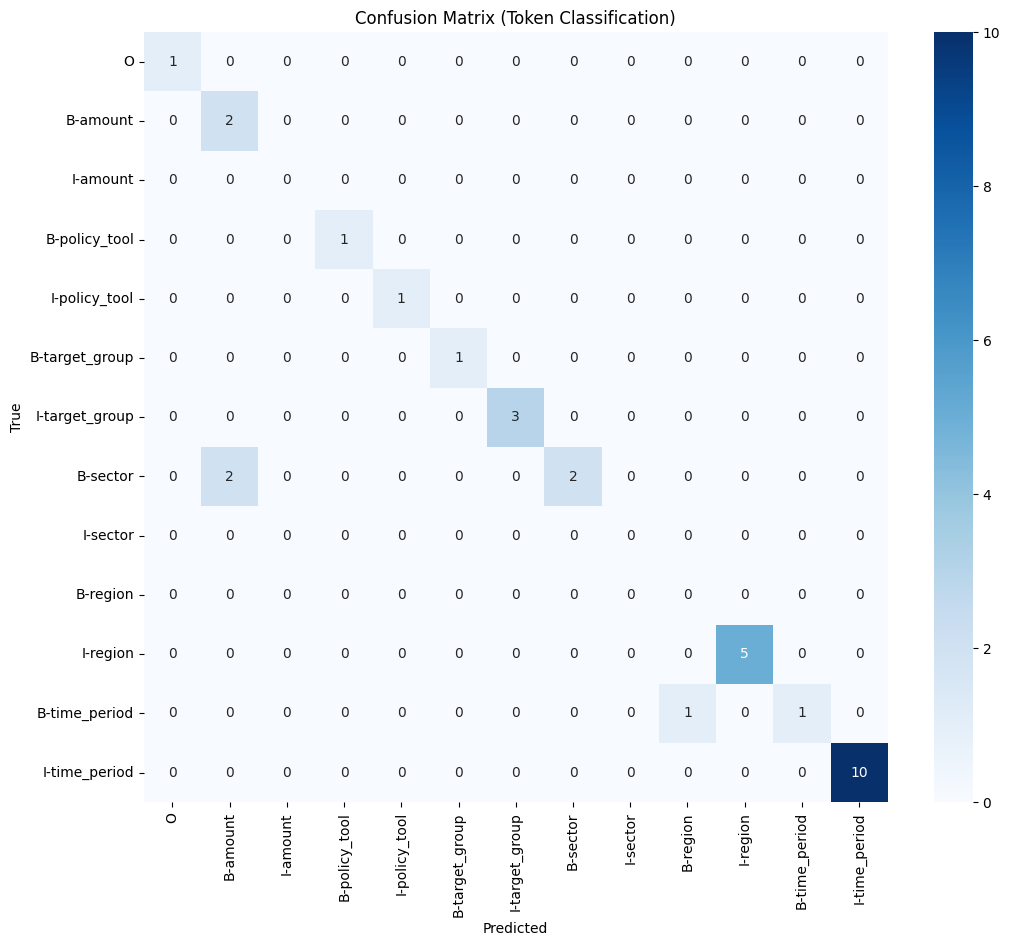

In [49]:
#Confusion matrix
cm = confusion_matrix(true_labels, true_preds, labels=label_list)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Token Classification)")
plt.show()
